## Deep Learning on FashionMNIST

*Import Libraries*

In [14]:
import time
import numpy as np

import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from PIL import Image
import datetime

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import cv2
sift = cv2.SIFT_create()

*Function Def*

In [20]:
def load_fashion_mnist_dataset():
    from keras.datasets import fashion_mnist
    ((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_fashion_mnist():
    (X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()
    plt.subplot(321)
    plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_train[4], cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
    plt.show()

def getImage(img_mat, gray=True, plot=False):
    '''
        @description returns a 32x32 image given a single row
        repr of the image
        _Optionally plots the image_
        @param img_mat -> np.array: |img_mat| = (3072, ) OR (3072, 1)
        @param plot -> bool: whether to plot it or not
        @return image_repr: np.ndarray |image_repr| = (32, 32, 3)
    '''
    assert img_mat.shape in [(3072,), (3072, 1)] # sanity check
    r_channel = img_mat[:1024].reshape(32, 32)
    g_channel = img_mat[1024: 2 * 1024].reshape(32, 32)
    b_channel = img_mat[2 * 1024:].reshape(32, 32)
    image_repr = np.stack([r_channel, g_channel, b_channel], axis=2)
    assert image_repr.shape == (32, 32, 3) # sanity check
    if plot:
        import matplotlib.pyplot as plt
        plt.imshow(image_repr), plt.show(block=False)

    return cv2.cvtColor(image_repr, cv2.COLOR_RGB2GRAY)

def show_rgb_img(img):
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def gen_sift_features(gray_img):
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

def getSIFT(img):
    '''
        @description Get the SIFT features of the input image
        @param img -> np.array: |img| => { (32, 32), (3072, 1||0) }
        @return descriptor -> np.array n x 128
    '''
    if img.shape in [(3072, 1), (3072,)]: img = getImage(img)
    kps, des = sift.detectAndCompute(img, None)
    return des if des is not None else np.array([]).reshape(0, 128)

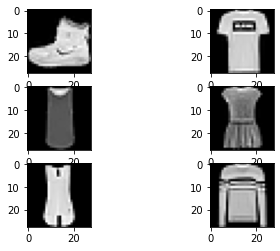

In [21]:
visualize_fashion_mnist()

## SIFT Based Classification

**Load the dataset**

In [22]:
(X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()

In [23]:
descriptors = []

start = time.time()
for img in X_train:
    des = getSIFT(img)
    for d in des:
        descriptors.append(d)
end = time.time()
print("Time: %0.2f" % (end - start), "seconds")

Time: 57.79 seconds


*Clustering With KMeans*

In [24]:
k=10**3
start = time.time()
kmeans = MiniBatchKMeans(n_clusters=k, verbose=1).fit(descriptors)
end = time.time()

Init 1/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 1/3: 2182158.616667
Init 2/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 2/3: 2639435.166667
Init 3/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 3/3: 2454201.588889
Minibatch iteration 1/241400: mean batch inertia: 53735.241944, ewa inertia: 53735.241944 
Minibatch iteration 2/241400: mean batch inertia: 53704.579783, ewa inertia: 53735.216540 
Minibatch iteration 3/241400: mean batch inertia: 58075.553300, ewa inertia: 53738.812586 
Minibatch iteration 4/241400: mean batch inertia: 53779.579889, ewa inertia: 53738.846362 
Minibatch iteration 5/241400: mean batch inertia: 49226.758054, ewa inertia: 53735.108018 
Minibatch iteration 6/241400: mean batch inertia: 51878.582545, ewa inertia: 53733.569854 
Minibatch iteration 7/241400: mean batch inertia: 58452.973037, ewa inertia: 53737.479962 
Minibatch iteration 8/241400: mean batch inertia: 45725.768404, ewa inertia: 53730.842118 
Minibatch iteration 9/241400: mean batch inertia: 52040.995993, ewa inertia: 53729.442051 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/241400: mean batch inertia: 52816.257959, ewa inertia: 53728.685462 
Mi

Minibatch iteration 94/241400: mean batch inertia: 40022.967755, ewa inertia: 53077.989078 
Minibatch iteration 95/241400: mean batch inertia: 36023.987007, ewa inertia: 53063.859537 
Minibatch iteration 96/241400: mean batch inertia: 41570.901270, ewa inertia: 53054.337419 
Minibatch iteration 97/241400: mean batch inertia: 45303.511213, ewa inertia: 53047.915724 
Minibatch iteration 98/241400: mean batch inertia: 39536.206823, ewa inertia: 53036.721035 
Minibatch iteration 99/241400: mean batch inertia: 45500.002833, ewa inertia: 53030.476732 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/241400: mean batch inertia: 34242.866123, ewa inertia: 53014.910866 
Minibatch iteration 101/241400: mean batch inertia: 43115.463858, ewa inertia: 53006.709001 
Minibatch iteration 102/241400: mean batch inertia: 38499.730872, ewa inertia: 52994.689714 
Minibatch iteration 103/241400: mean batch inertia: 42011.287213, ewa inertia: 52985.589772 
Minibatch iteration 104/24

Minibatch iteration 189/241400: mean batch inertia: 33059.519173, ewa inertia: 52044.552297 
Minibatch iteration 190/241400: mean batch inertia: 39411.954587, ewa inertia: 52034.085968 
Minibatch iteration 191/241400: mean batch inertia: 34019.660931, ewa inertia: 52019.160700 
Minibatch iteration 192/241400: mean batch inertia: 41983.328731, ewa inertia: 52010.845837 
Minibatch iteration 193/241400: mean batch inertia: 33722.362652, ewa inertia: 51995.693507 
Minibatch iteration 194/241400: mean batch inertia: 40157.597850, ewa inertia: 51985.885437 
Minibatch iteration 195/241400: mean batch inertia: 38706.076151, ewa inertia: 51974.882882 
Minibatch iteration 196/241400: mean batch inertia: 42504.545703, ewa inertia: 51967.036541 
Minibatch iteration 197/241400: mean batch inertia: 35800.698294, ewa inertia: 51953.642446 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 198/241400: mean batch inertia: 34765.495895, ewa inertia: 51939.401764 
Minibatch iteration 

Minibatch iteration 282/241400: mean batch inertia: 35019.627553, ewa inertia: 50970.526309 
Minibatch iteration 283/241400: mean batch inertia: 37633.978643, ewa inertia: 50959.476745 
Minibatch iteration 284/241400: mean batch inertia: 33200.048483, ewa inertia: 50944.762746 
Minibatch iteration 285/241400: mean batch inertia: 33637.764074, ewa inertia: 50930.423594 
Minibatch iteration 286/241400: mean batch inertia: 36823.398653, ewa inertia: 50918.735675 
Minibatch iteration 287/241400: mean batch inertia: 35132.476411, ewa inertia: 50905.656482 
Minibatch iteration 288/241400: mean batch inertia: 34848.540048, ewa inertia: 50892.352879 
Minibatch iteration 289/241400: mean batch inertia: 36846.629723, ewa inertia: 50880.715751 
Minibatch iteration 290/241400: mean batch inertia: 38700.324326, ewa inertia: 50870.624082 
Minibatch iteration 291/241400: mean batch inertia: 33722.512054, ewa inertia: 50856.416570 
Minibatch iteration 292/241400: mean batch inertia: 37637.724806, ewa 

Minibatch iteration 383/241400: mean batch inertia: 40281.917120, ewa inertia: 49862.195254 
Minibatch iteration 384/241400: mean batch inertia: 33008.418755, ewa inertia: 49848.231604 
Minibatch iteration 385/241400: mean batch inertia: 36316.573834, ewa inertia: 49837.020387 
Minibatch iteration 386/241400: mean batch inertia: 36629.484540, ewa inertia: 49826.077712 
Minibatch iteration 387/241400: mean batch inertia: 32318.744029, ewa inertia: 49811.572578 
Minibatch iteration 388/241400: mean batch inertia: 35136.203251, ewa inertia: 49799.413777 
Minibatch iteration 389/241400: mean batch inertia: 34167.819453, ewa inertia: 49786.462726 
Minibatch iteration 390/241400: mean batch inertia: 39343.117791, ewa inertia: 49777.810231 
Minibatch iteration 391/241400: mean batch inertia: 38446.087243, ewa inertia: 49768.421700 
Minibatch iteration 392/241400: mean batch inertia: 38844.382303, ewa inertia: 49759.370941 
Minibatch iteration 393/241400: mean batch inertia: 37569.294099, ewa 

Minibatch iteration 478/241400: mean batch inertia: 36761.574382, ewa inertia: 48889.284984 
Minibatch iteration 479/241400: mean batch inertia: 39335.538691, ewa inertia: 48881.369537 
Minibatch iteration 480/241400: mean batch inertia: 41814.757724, ewa inertia: 48875.514725 
Minibatch iteration 481/241400: mean batch inertia: 34479.253838, ewa inertia: 48863.587170 
Minibatch iteration 482/241400: mean batch inertia: 34729.161245, ewa inertia: 48851.876550 
Minibatch iteration 483/241400: mean batch inertia: 40109.012148, ewa inertia: 48844.632933 
Minibatch iteration 484/241400: mean batch inertia: 37216.764543, ewa inertia: 48834.999040 
Minibatch iteration 485/241400: mean batch inertia: 33461.961375, ewa inertia: 48822.262208 
Minibatch iteration 486/241400: mean batch inertia: 38179.819152, ewa inertia: 48813.444757 
Minibatch iteration 487/241400: mean batch inertia: 34528.735087, ewa inertia: 48801.609624 
Minibatch iteration 488/241400: mean batch inertia: 34960.628565, ewa 

Minibatch iteration 570/241400: mean batch inertia: 36715.843053, ewa inertia: 47961.040457 
Minibatch iteration 571/241400: mean batch inertia: 39631.322582, ewa inertia: 47954.139140 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch iteration 572/241400: mean batch inertia: 35313.793263, ewa inertia: 47943.666391 
Minibatch iteration 573/241400: mean batch inertia: 32514.104192, ewa inertia: 47930.882728 
Minibatch iteration 574/241400: mean batch inertia: 34498.242626, ewa inertia: 47919.753549 
Minibatch iteration 575/241400: mean batch inertia: 31972.441679, ewa inertia: 47906.540921 
Minibatch iteration 576/241400: mean batch inertia: 35073.772506, ewa inertia: 47895.908747 
Minibatch iteration 577/241400: mean batch inertia: 38963.671942, ewa inertia: 47888.508232 
Minibatch iteration 578/241400: mean batch inertia: 38989.399483, ewa inertia: 47881.135164 
Minibatch iteration 579/241400: mean batch inertia: 37499.833630, ewa inertia: 47872.534073 
Minibatch iteration 5

Minibatch iteration 667/241400: mean batch inertia: 30733.476364, ewa inertia: 47058.376118 
Minibatch iteration 668/241400: mean batch inertia: 34136.888509, ewa inertia: 47047.670439 
Minibatch iteration 669/241400: mean batch inertia: 40007.553105, ewa inertia: 47041.837578 
Minibatch iteration 670/241400: mean batch inertia: 34803.177426, ewa inertia: 47031.697633 
Minibatch iteration 671/241400: mean batch inertia: 38169.639617, ewa inertia: 47024.355262 
Minibatch iteration 672/241400: mean batch inertia: 39869.060970, ewa inertia: 47018.426975 
Minibatch iteration 673/241400: mean batch inertia: 30841.177028, ewa inertia: 47005.023839 
Minibatch iteration 674/241400: mean batch inertia: 34586.913238, ewa inertia: 46994.735216 
Minibatch iteration 675/241400: mean batch inertia: 34617.550034, ewa inertia: 46984.480501 
Minibatch iteration 676/241400: mean batch inertia: 35536.098454, ewa inertia: 46974.995315 
Minibatch iteration 677/241400: mean batch inertia: 34765.764277, ewa 

Minibatch iteration 757/241400: mean batch inertia: 39321.176991, ewa inertia: 46270.871357 
Minibatch iteration 758/241400: mean batch inertia: 37764.754484, ewa inertia: 46263.823889 
Minibatch iteration 759/241400: mean batch inertia: 39961.616045, ewa inertia: 46258.602399 
Minibatch iteration 760/241400: mean batch inertia: 38173.382466, ewa inertia: 46251.903652 
Minibatch iteration 761/241400: mean batch inertia: 35648.645526, ewa inertia: 46243.118667 
Minibatch iteration 762/241400: mean batch inertia: 38978.002032, ewa inertia: 46237.099390 
Minibatch iteration 763/241400: mean batch inertia: 33340.064614, ewa inertia: 46226.413970 
Minibatch iteration 764/241400: mean batch inertia: 39535.366875, ewa inertia: 46220.870320 
Minibatch iteration 765/241400: mean batch inertia: 38250.145694, ewa inertia: 46214.266434 
Minibatch iteration 766/241400: mean batch inertia: 39681.394894, ewa inertia: 46208.853836 
Minibatch iteration 767/241400: mean batch inertia: 33487.773789, ewa 

Minibatch iteration 854/241400: mean batch inertia: 35743.855566, ewa inertia: 45462.718027 
Minibatch iteration 855/241400: mean batch inertia: 32828.489919, ewa inertia: 45452.250347 
Minibatch iteration 856/241400: mean batch inertia: 36735.880937, ewa inertia: 45445.028682 
Minibatch iteration 857/241400: mean batch inertia: 37475.367728, ewa inertia: 45438.425678 
Minibatch iteration 858/241400: mean batch inertia: 32692.340982, ewa inertia: 45427.865323 
Minibatch iteration 859/241400: mean batch inertia: 35667.248279, ewa inertia: 45419.778480 
Minibatch iteration 860/241400: mean batch inertia: 35321.568695, ewa inertia: 45411.411936 
Minibatch iteration 861/241400: mean batch inertia: 34689.091271, ewa inertia: 45402.528305 
Minibatch iteration 862/241400: mean batch inertia: 33694.115748, ewa inertia: 45392.827679 
Minibatch iteration 863/241400: mean batch inertia: 33205.575690, ewa inertia: 45382.730327 
Minibatch iteration 864/241400: mean batch inertia: 35392.278218, ewa 

Minibatch iteration 953/241400: mean batch inertia: 35003.056852, ewa inertia: 44688.034128 
Minibatch iteration 954/241400: mean batch inertia: 39919.318434, ewa inertia: 44684.083163 
Minibatch iteration 955/241400: mean batch inertia: 41243.006720, ewa inertia: 44681.232171 
Minibatch iteration 956/241400: mean batch inertia: 29660.996920, ewa inertia: 44668.787642 
Minibatch iteration 957/241400: mean batch inertia: 37845.204964, ewa inertia: 44663.134183 
Minibatch iteration 958/241400: mean batch inertia: 31024.992734, ewa inertia: 44651.834744 
Minibatch iteration 959/241400: mean batch inertia: 37803.772011, ewa inertia: 44646.161003 
Minibatch iteration 960/241400: mean batch inertia: 38536.261147, ewa inertia: 44641.098844 
Minibatch iteration 961/241400: mean batch inertia: 32602.481087, ewa inertia: 44631.124637 
Minibatch iteration 962/241400: mean batch inertia: 39033.001719, ewa inertia: 44626.486494 
Minibatch iteration 963/241400: mean batch inertia: 31213.122467, ewa 

Minibatch iteration 1049/241400: mean batch inertia: 39085.673672, ewa inertia: 43962.291247 
Minibatch iteration 1050/241400: mean batch inertia: 35430.376071, ewa inertia: 43955.222406 
Minibatch iteration 1051/241400: mean batch inertia: 33920.080713, ewa inertia: 43946.908114 
Minibatch iteration 1052/241400: mean batch inertia: 35256.901567, ewa inertia: 43939.708291 
Minibatch iteration 1053/241400: mean batch inertia: 39327.979281, ewa inertia: 43935.887393 
Minibatch iteration 1054/241400: mean batch inertia: 38425.998901, ewa inertia: 43931.322353 
Minibatch iteration 1055/241400: mean batch inertia: 37942.235377, ewa inertia: 43926.360289 
Minibatch iteration 1056/241400: mean batch inertia: 31346.638349, ewa inertia: 43915.937769 
Minibatch iteration 1057/241400: mean batch inertia: 37397.897785, ewa inertia: 43910.537458 
Minibatch iteration 1058/241400: mean batch inertia: 33928.958427, ewa inertia: 43902.267544 
Minibatch iteration 1059/241400: mean batch inertia: 34656.9

Minibatch iteration 1143/241400: mean batch inertia: 36708.317162, ewa inertia: 43307.578951 
Minibatch iteration 1144/241400: mean batch inertia: 33878.977402, ewa inertia: 43299.767189 
Minibatch iteration 1145/241400: mean batch inertia: 33991.639620, ewa inertia: 43292.055242 
Minibatch iteration 1146/241400: mean batch inertia: 33503.279433, ewa inertia: 43283.945069 
Minibatch iteration 1147/241400: mean batch inertia: 35810.477861, ewa inertia: 43277.753170 
Minibatch iteration 1148/241400: mean batch inertia: 36155.222156, ewa inertia: 43271.852028 
Minibatch iteration 1149/241400: mean batch inertia: 34665.545601, ewa inertia: 43264.721552 
Minibatch iteration 1150/241400: mean batch inertia: 38296.793715, ewa inertia: 43260.605537 
Minibatch iteration 1151/241400: mean batch inertia: 36185.253687, ewa inertia: 43254.743483 
Minibatch iteration 1152/241400: mean batch inertia: 34714.834013, ewa inertia: 43247.668018 
Minibatch iteration 1153/241400: mean batch inertia: 32883.4

Minibatch iteration 1231/241400: mean batch inertia: 34826.167433, ewa inertia: 42709.575996 
Minibatch iteration 1232/241400: mean batch inertia: 34012.935565, ewa inertia: 42702.370677 
Minibatch iteration 1233/241400: mean batch inertia: 41699.699801, ewa inertia: 42701.539946 
Minibatch iteration 1234/241400: mean batch inertia: 31860.164235, ewa inertia: 42692.557676 
Minibatch iteration 1235/241400: mean batch inertia: 33366.453269, ewa inertia: 42684.830835 
Minibatch iteration 1236/241400: mean batch inertia: 35327.515434, ewa inertia: 42678.735170 
Minibatch iteration 1237/241400: mean batch inertia: 34325.394006, ewa inertia: 42671.814280 
Minibatch iteration 1238/241400: mean batch inertia: 33206.251288, ewa inertia: 42663.971894 
Minibatch iteration 1239/241400: mean batch inertia: 38228.001020, ewa inertia: 42660.296614 
Minibatch iteration 1240/241400: mean batch inertia: 40721.728774, ewa inertia: 42658.690477 
Minibatch iteration 1241/241400: mean batch inertia: 37799.6

Minibatch iteration 1321/241400: mean batch inertia: 34505.521967, ewa inertia: 42193.986698 
Minibatch iteration 1322/241400: mean batch inertia: 35173.701357, ewa inertia: 42188.170268 
Minibatch iteration 1323/241400: mean batch inertia: 33305.006351, ewa inertia: 42180.810411 
Minibatch iteration 1324/241400: mean batch inertia: 35505.520178, ewa inertia: 42175.279815 
Minibatch iteration 1325/241400: mean batch inertia: 30953.649608, ewa inertia: 42165.982497 
Minibatch iteration 1326/241400: mean batch inertia: 36655.900719, ewa inertia: 42161.417298 
Minibatch iteration 1327/241400: mean batch inertia: 32834.267970, ewa inertia: 42153.689591 
Minibatch iteration 1328/241400: mean batch inertia: 31729.686685, ewa inertia: 42145.053121 
Minibatch iteration 1329/241400: mean batch inertia: 36794.809227, ewa inertia: 42140.620350 
Minibatch iteration 1330/241400: mean batch inertia: 41236.480877, ewa inertia: 42139.871255 
Minibatch iteration 1331/241400: mean batch inertia: 32125.5

Minibatch iteration 1418/241400: mean batch inertia: 37474.128370, ewa inertia: 41641.808237 
Minibatch iteration 1419/241400: mean batch inertia: 36389.222157, ewa inertia: 41637.456377 
Minibatch iteration 1420/241400: mean batch inertia: 36065.535271, ewa inertia: 41632.839943 
Minibatch iteration 1421/241400: mean batch inertia: 31765.953297, ewa inertia: 41624.665054 
Minibatch iteration 1422/241400: mean batch inertia: 34118.262785, ewa inertia: 41618.445868 
Minibatch iteration 1423/241400: mean batch inertia: 33606.340971, ewa inertia: 41611.807698 
Minibatch iteration 1424/241400: mean batch inertia: 33022.499845, ewa inertia: 41604.691305 
Minibatch iteration 1425/241400: mean batch inertia: 36965.659495, ewa inertia: 41600.847786 
Minibatch iteration 1426/241400: mean batch inertia: 34950.119470, ewa inertia: 41595.337541 
Minibatch iteration 1427/241400: mean batch inertia: 32983.356287, ewa inertia: 41588.202363 
Minibatch iteration 1428/241400: mean batch inertia: 34840.9

Minibatch iteration 1514/241400: mean batch inertia: 34653.268214, ewa inertia: 41146.025948 
Minibatch iteration 1515/241400: mean batch inertia: 33142.086252, ewa inertia: 41139.394543 
Minibatch iteration 1516/241400: mean batch inertia: 37429.000616, ewa inertia: 41136.320417 
Minibatch iteration 1517/241400: mean batch inertia: 39334.898077, ewa inertia: 41134.827907 
Minibatch iteration 1518/241400: mean batch inertia: 35076.848120, ewa inertia: 41129.808764 
Minibatch iteration 1519/241400: mean batch inertia: 33493.516828, ewa inertia: 41123.481962 
Minibatch iteration 1520/241400: mean batch inertia: 36658.103223, ewa inertia: 41119.782317 
Minibatch iteration 1521/241400: mean batch inertia: 31044.596276, ewa inertia: 41111.434848 
Minibatch iteration 1522/241400: mean batch inertia: 39567.545855, ewa inertia: 41110.155709 
Minibatch iteration 1523/241400: mean batch inertia: 33793.537084, ewa inertia: 41104.093762 
Minibatch iteration 1524/241400: mean batch inertia: 36120.8

Minibatch iteration 1601/241400: mean batch inertia: 34263.546555, ewa inertia: 40765.585543 
Minibatch iteration 1602/241400: mean batch inertia: 31088.786258, ewa inertia: 40757.568145 
Minibatch iteration 1603/241400: mean batch inertia: 35038.796281, ewa inertia: 40752.830042 
Minibatch iteration 1604/241400: mean batch inertia: 33402.024936, ewa inertia: 40746.739771 
Minibatch iteration 1605/241400: mean batch inertia: 32454.876787, ewa inertia: 40739.869816 
Minibatch iteration 1606/241400: mean batch inertia: 34194.522186, ewa inertia: 40734.446881 
Minibatch iteration 1607/241400: mean batch inertia: 37393.645548, ewa inertia: 40731.678968 
Minibatch iteration 1608/241400: mean batch inertia: 31034.476042, ewa inertia: 40723.644665 
Minibatch iteration 1609/241400: mean batch inertia: 39140.478748, ewa inertia: 40722.332984 
Minibatch iteration 1610/241400: mean batch inertia: 36776.449738, ewa inertia: 40719.063751 
Minibatch iteration 1611/241400: mean batch inertia: 34769.2

Minibatch iteration 1700/241400: mean batch inertia: 37128.578231, ewa inertia: 40310.865420 
Minibatch iteration 1701/241400: mean batch inertia: 32400.400505, ewa inertia: 40304.311461 
Minibatch iteration 1702/241400: mean batch inertia: 34543.206420, ewa inertia: 40299.538284 
Minibatch iteration 1703/241400: mean batch inertia: 38302.884894, ewa inertia: 40297.884021 
Minibatch iteration 1704/241400: mean batch inertia: 33596.456269, ewa inertia: 40292.331771 
Minibatch iteration 1705/241400: mean batch inertia: 33168.079357, ewa inertia: 40286.429202 
Minibatch iteration 1706/241400: mean batch inertia: 35334.035373, ewa inertia: 40282.326057 
Minibatch iteration 1707/241400: mean batch inertia: 36648.874909, ewa inertia: 40279.315679 
Minibatch iteration 1708/241400: mean batch inertia: 38649.838305, ewa inertia: 40277.965628 
Minibatch iteration 1709/241400: mean batch inertia: 34991.908591, ewa inertia: 40273.586037 
Minibatch iteration 1710/241400: mean batch inertia: 35390.9

Minibatch iteration 1790/241400: mean batch inertia: 36552.637260, ewa inertia: 39929.735380 
Minibatch iteration 1791/241400: mean batch inertia: 40513.301888, ewa inertia: 39930.218875 
Minibatch iteration 1792/241400: mean batch inertia: 35662.146585, ewa inertia: 39926.682702 
Minibatch iteration 1793/241400: mean batch inertia: 34328.578363, ewa inertia: 39922.044574 
Minibatch iteration 1794/241400: mean batch inertia: 34264.033205, ewa inertia: 39917.356812 
Minibatch iteration 1795/241400: mean batch inertia: 34864.231809, ewa inertia: 39913.170209 
Minibatch iteration 1796/241400: mean batch inertia: 35648.445309, ewa inertia: 39909.636810 
Minibatch iteration 1797/241400: mean batch inertia: 36972.443096, ewa inertia: 39907.203293 
Minibatch iteration 1798/241400: mean batch inertia: 34115.272902, ewa inertia: 39902.404577 
Minibatch iteration 1799/241400: mean batch inertia: 36864.909089, ewa inertia: 39899.887959 
Minibatch iteration 1800/241400: mean batch inertia: 38073.8

Minibatch iteration 1883/241400: mean batch inertia: 36644.050807, ewa inertia: 39561.281263 
Minibatch iteration 1884/241400: mean batch inertia: 40774.965182, ewa inertia: 39562.286821 
Minibatch iteration 1885/241400: mean batch inertia: 35222.681082, ewa inertia: 39558.691382 
Minibatch iteration 1886/241400: mean batch inertia: 30977.016470, ewa inertia: 39551.581313 
Minibatch iteration 1887/241400: mean batch inertia: 36350.091501, ewa inertia: 39548.928823 
Minibatch iteration 1888/241400: mean batch inertia: 33429.846418, ewa inertia: 39543.859055 
Minibatch iteration 1889/241400: mean batch inertia: 34580.547119, ewa inertia: 39539.746864 
Minibatch iteration 1890/241400: mean batch inertia: 36459.195913, ewa inertia: 39537.194573 
Minibatch iteration 1891/241400: mean batch inertia: 33677.047848, ewa inertia: 39532.339339 
Minibatch iteration 1892/241400: mean batch inertia: 35823.314068, ewa inertia: 39529.266346 
Minibatch iteration 1893/241400: mean batch inertia: 35071.8

Minibatch iteration 1974/241400: mean batch inertia: 31775.393773, ewa inertia: 39229.660521 
Minibatch iteration 1975/241400: mean batch inertia: 31868.501758, ewa inertia: 39223.561672 
Minibatch iteration 1976/241400: mean batch inertia: 37374.499876, ewa inertia: 39222.029692 
Minibatch iteration 1977/241400: mean batch inertia: 35376.991014, ewa inertia: 39218.844010 
Minibatch iteration 1978/241400: mean batch inertia: 35422.277656, ewa inertia: 39215.698488 
Minibatch iteration 1979/241400: mean batch inertia: 35194.323675, ewa inertia: 39212.366708 
Minibatch iteration 1980/241400: mean batch inertia: 33997.835441, ewa inertia: 39208.046377 
Minibatch iteration 1981/241400: mean batch inertia: 35914.973827, ewa inertia: 39205.318009 
Minibatch iteration 1982/241400: mean batch inertia: 38485.799012, ewa inertia: 39204.721875 
Minibatch iteration 1983/241400: mean batch inertia: 32424.324591, ewa inertia: 39199.104196 
Minibatch iteration 1984/241400: mean batch inertia: 35515.6

Minibatch iteration 2065/241400: mean batch inertia: 32581.340957, ewa inertia: 38936.829619 
Minibatch iteration 2066/241400: mean batch inertia: 35828.353638, ewa inertia: 38934.254192 
Minibatch iteration 2067/241400: mean batch inertia: 35950.291917, ewa inertia: 38931.781927 
Minibatch iteration 2068/241400: mean batch inertia: 36939.570951, ewa inertia: 38930.131345 
Minibatch iteration 2069/241400: mean batch inertia: 40656.982823, ewa inertia: 38931.562072 
Minibatch iteration 2070/241400: mean batch inertia: 33282.308480, ewa inertia: 38926.881566 
Minibatch iteration 2071/241400: mean batch inertia: 33803.118138, ewa inertia: 38922.636438 
Minibatch iteration 2072/241400: mean batch inertia: 37810.466654, ewa inertia: 38921.714985 
Minibatch iteration 2073/241400: mean batch inertia: 30237.227887, ewa inertia: 38914.519735 
Minibatch iteration 2074/241400: mean batch inertia: 34539.943159, ewa inertia: 38910.895322 
Minibatch iteration 2075/241400: mean batch inertia: 35211.8

Minibatch iteration 2158/241400: mean batch inertia: 37501.264801, ewa inertia: 38640.182421 
Minibatch iteration 2159/241400: mean batch inertia: 32738.974945, ewa inertia: 38635.293167 
Minibatch iteration 2160/241400: mean batch inertia: 38946.989688, ewa inertia: 38635.551413 
Minibatch iteration 2161/241400: mean batch inertia: 31370.707370, ewa inertia: 38629.532362 
Minibatch iteration 2162/241400: mean batch inertia: 37711.049188, ewa inertia: 38628.771382 
Minibatch iteration 2163/241400: mean batch inertia: 35651.738550, ewa inertia: 38626.304858 
Minibatch iteration 2164/241400: mean batch inertia: 36317.082476, ewa inertia: 38624.391627 
Minibatch iteration 2165/241400: mean batch inertia: 31141.155056, ewa inertia: 38618.191634 
Minibatch iteration 2166/241400: mean batch inertia: 38340.052869, ewa inertia: 38617.961191 
Minibatch iteration 2167/241400: mean batch inertia: 36824.606380, ewa inertia: 38616.475365 
Minibatch iteration 2168/241400: mean batch inertia: 34124.8

Minibatch iteration 2253/241400: mean batch inertia: 36478.999816, ewa inertia: 38350.794827 
Minibatch iteration 2254/241400: mean batch inertia: 36884.767055, ewa inertia: 38349.580197 
Minibatch iteration 2255/241400: mean batch inertia: 32834.298507, ewa inertia: 38345.010689 
Minibatch iteration 2256/241400: mean batch inertia: 29972.342867, ewa inertia: 38338.073787 
Minibatch iteration 2257/241400: mean batch inertia: 32765.995675, ewa inertia: 38333.457222 
Minibatch iteration 2258/241400: mean batch inertia: 35534.133905, ewa inertia: 38331.137933 
Minibatch iteration 2259/241400: mean batch inertia: 34194.353608, ewa inertia: 38327.710535 
Minibatch iteration 2260/241400: mean batch inertia: 36159.682056, ewa inertia: 38325.914285 
Minibatch iteration 2261/241400: mean batch inertia: 38208.163267, ewa inertia: 38325.816726 
Minibatch iteration 2262/241400: mean batch inertia: 30560.426665, ewa inertia: 38319.382964 
Minibatch iteration 2263/241400: mean batch inertia: 43069.5

Minibatch iteration 2341/241400: mean batch inertia: 37351.481645, ewa inertia: 38090.253371 
Minibatch iteration 2342/241400: mean batch inertia: 34111.612997, ewa inertia: 38086.956998 
Minibatch iteration 2343/241400: mean batch inertia: 29896.383542, ewa inertia: 38080.170963 
Minibatch iteration 2344/241400: mean batch inertia: 32890.582759, ewa inertia: 38075.871298 
Minibatch iteration 2345/241400: mean batch inertia: 36483.845723, ewa inertia: 38074.552277 
Minibatch iteration 2346/241400: mean batch inertia: 39360.319371, ewa inertia: 38075.617558 
Minibatch iteration 2347/241400: mean batch inertia: 32910.947314, ewa inertia: 38071.338538 
Minibatch iteration 2348/241400: mean batch inertia: 32366.185376, ewa inertia: 38066.611718 
Minibatch iteration 2349/241400: mean batch inertia: 42427.208888, ewa inertia: 38070.224550 
Minibatch iteration 2350/241400: mean batch inertia: 36338.526084, ewa inertia: 38068.789807 
Minibatch iteration 2351/241400: mean batch inertia: 29321.1

Minibatch iteration 2436/241400: mean batch inertia: 33206.242636, ewa inertia: 37897.728489 
Minibatch iteration 2437/241400: mean batch inertia: 40770.486620, ewa inertia: 37900.108620 
Minibatch iteration 2438/241400: mean batch inertia: 38741.081900, ewa inertia: 37900.805381 
Minibatch iteration 2439/241400: mean batch inertia: 36223.768423, ewa inertia: 37899.415926 
Minibatch iteration 2440/241400: mean batch inertia: 35870.484925, ewa inertia: 37897.734921 
Minibatch iteration 2441/241400: mean batch inertia: 34993.104263, ewa inertia: 37895.328384 
Minibatch iteration 2442/241400: mean batch inertia: 31662.626460, ewa inertia: 37890.164481 
Minibatch iteration 2443/241400: mean batch inertia: 37532.632207, ewa inertia: 37889.868259 
Minibatch iteration 2444/241400: mean batch inertia: 33481.191941, ewa inertia: 37886.215593 
Minibatch iteration 2445/241400: mean batch inertia: 37021.593794, ewa inertia: 37885.499239 
Minibatch iteration 2446/241400: mean batch inertia: 36997.1

Minibatch iteration 2525/241400: mean batch inertia: 38390.936524, ewa inertia: 37741.447148 
Minibatch iteration 2526/241400: mean batch inertia: 35879.178679, ewa inertia: 37739.904226 
Minibatch iteration 2527/241400: mean batch inertia: 35728.934655, ewa inertia: 37738.238103 
Minibatch iteration 2528/241400: mean batch inertia: 32364.005952, ewa inertia: 37733.785457 
Minibatch iteration 2529/241400: mean batch inertia: 36876.333908, ewa inertia: 37733.075043 
Minibatch iteration 2530/241400: mean batch inertia: 35635.344906, ewa inertia: 37731.337037 
Minibatch iteration 2531/241400: mean batch inertia: 32346.081975, ewa inertia: 37726.875258 
Minibatch iteration 2532/241400: mean batch inertia: 31770.116791, ewa inertia: 37721.939979 
Minibatch iteration 2533/241400: mean batch inertia: 36605.985750, ewa inertia: 37721.015392 
Minibatch iteration 2534/241400: mean batch inertia: 40055.677759, ewa inertia: 37722.949700 
Minibatch iteration 2535/241400: mean batch inertia: 36090.5

Minibatch iteration 2620/241400: mean batch inertia: 30674.811712, ewa inertia: 37503.381315 
Minibatch iteration 2621/241400: mean batch inertia: 29880.435405, ewa inertia: 37497.065570 
Minibatch iteration 2622/241400: mean batch inertia: 35705.430234, ewa inertia: 37495.581169 
Minibatch iteration 2623/241400: mean batch inertia: 36063.770083, ewa inertia: 37494.394888 
Minibatch iteration 2624/241400: mean batch inertia: 35715.475266, ewa inertia: 37492.921022 
Minibatch iteration 2625/241400: mean batch inertia: 34569.416250, ewa inertia: 37490.498847 
Minibatch iteration 2626/241400: mean batch inertia: 36334.374268, ewa inertia: 37489.540977 
Minibatch iteration 2627/241400: mean batch inertia: 35261.220295, ewa inertia: 37487.694775 
Minibatch iteration 2628/241400: mean batch inertia: 34993.089014, ewa inertia: 37485.627950 
Minibatch iteration 2629/241400: mean batch inertia: 34212.659498, ewa inertia: 37482.916238 
Minibatch iteration 2630/241400: mean batch inertia: 28094.5

Minibatch iteration 2721/241400: mean batch inertia: 34907.266648, ewa inertia: 37273.985847 
Minibatch iteration 2722/241400: mean batch inertia: 33190.694319, ewa inertia: 37270.602768 
Minibatch iteration 2723/241400: mean batch inertia: 33842.123102, ewa inertia: 37267.762213 
Minibatch iteration 2724/241400: mean batch inertia: 38663.583287, ewa inertia: 37268.918675 
Minibatch iteration 2725/241400: mean batch inertia: 30891.558256, ewa inertia: 37263.634920 
Minibatch iteration 2726/241400: mean batch inertia: 37613.037254, ewa inertia: 37263.924406 
Minibatch iteration 2727/241400: mean batch inertia: 35208.182172, ewa inertia: 37262.221187 
Minibatch iteration 2728/241400: mean batch inertia: 35074.561154, ewa inertia: 37260.408672 
Minibatch iteration 2729/241400: mean batch inertia: 39334.174222, ewa inertia: 37262.126823 
Minibatch iteration 2730/241400: mean batch inertia: 35615.917979, ewa inertia: 37260.762910 
Minibatch iteration 2731/241400: mean batch inertia: 34536.5

Minibatch iteration 2819/241400: mean batch inertia: 37276.059678, ewa inertia: 37081.410023 
Minibatch iteration 2820/241400: mean batch inertia: 41378.855373, ewa inertia: 37084.970532 
Minibatch iteration 2821/241400: mean batch inertia: 36014.777358, ewa inertia: 37084.083858 
Minibatch iteration 2822/241400: mean batch inertia: 35217.203144, ewa inertia: 37082.537115 
Minibatch iteration 2823/241400: mean batch inertia: 39439.379681, ewa inertia: 37084.489800 
Minibatch iteration 2824/241400: mean batch inertia: 34354.451530, ewa inertia: 37082.227915 
Minibatch iteration 2825/241400: mean batch inertia: 35466.184789, ewa inertia: 37080.888995 
Minibatch iteration 2826/241400: mean batch inertia: 36097.734387, ewa inertia: 37080.074434 
Minibatch iteration 2827/241400: mean batch inertia: 35216.485187, ewa inertia: 37078.530418 
Minibatch iteration 2828/241400: mean batch inertia: 39415.857491, ewa inertia: 37080.466934 
Minibatch iteration 2829/241400: mean batch inertia: 34074.3

Minibatch iteration 2906/241400: mean batch inertia: 34925.021059, ewa inertia: 36901.908304 
Minibatch iteration 2907/241400: mean batch inertia: 36501.169120, ewa inertia: 36901.576285 
Minibatch iteration 2908/241400: mean batch inertia: 34680.572878, ewa inertia: 36899.736144 
Minibatch iteration 2909/241400: mean batch inertia: 37631.247185, ewa inertia: 36900.342214 
Minibatch iteration 2910/241400: mean batch inertia: 35606.572460, ewa inertia: 36899.270303 
Minibatch iteration 2911/241400: mean batch inertia: 35197.419909, ewa inertia: 36897.860290 
Minibatch iteration 2912/241400: mean batch inertia: 31858.429136, ewa inertia: 36893.685033 
Minibatch iteration 2913/241400: mean batch inertia: 36107.372023, ewa inertia: 36893.033559 
Minibatch iteration 2914/241400: mean batch inertia: 33128.056722, ewa inertia: 36889.914209 
Minibatch iteration 2915/241400: mean batch inertia: 32816.114502, ewa inertia: 36886.538995 
Minibatch iteration 2916/241400: mean batch inertia: 35585.2

Minibatch iteration 2999/241400: mean batch inertia: 36565.713775, ewa inertia: 36724.874457 
Minibatch iteration 3000/241400: mean batch inertia: 36697.675285, ewa inertia: 36724.851922 
Minibatch iteration 3001/241400: mean batch inertia: 32185.410825, ewa inertia: 36721.090916 
Minibatch iteration 3002/241400: mean batch inertia: 32425.363196, ewa inertia: 36717.531830 
Minibatch iteration 3003/241400: mean batch inertia: 33095.806139, ewa inertia: 36714.531166 
Minibatch iteration 3004/241400: mean batch inertia: 32744.533907, ewa inertia: 36711.241954 
Minibatch iteration 3005/241400: mean batch inertia: 35402.857973, ewa inertia: 36710.157935 
Minibatch iteration 3006/241400: mean batch inertia: 35325.789611, ewa inertia: 36709.010961 
Minibatch iteration 3007/241400: mean batch inertia: 40994.331221, ewa inertia: 36712.561424 
Minibatch iteration 3008/241400: mean batch inertia: 30473.486925, ewa inertia: 36707.392242 
Minibatch iteration 3009/241400: mean batch inertia: 36226.4

Minibatch iteration 3094/241400: mean batch inertia: 33867.267672, ewa inertia: 36599.187130 
Minibatch iteration 3095/241400: mean batch inertia: 34613.217450, ewa inertia: 36597.541719 
Minibatch iteration 3096/241400: mean batch inertia: 33981.235050, ewa inertia: 36595.374063 
Minibatch iteration 3097/241400: mean batch inertia: 36295.427090, ewa inertia: 36595.125552 
Minibatch iteration 3098/241400: mean batch inertia: 37113.121679, ewa inertia: 36595.554721 
Minibatch iteration 3099/241400: mean batch inertia: 41762.623234, ewa inertia: 36599.835728 
Minibatch iteration 3100/241400: mean batch inertia: 38201.623395, ewa inertia: 36601.162837 
Minibatch iteration 3101/241400: mean batch inertia: 34642.693420, ewa inertia: 36599.540211 
Minibatch iteration 3102/241400: mean batch inertia: 38278.081341, ewa inertia: 36600.930912 
Minibatch iteration 3103/241400: mean batch inertia: 38451.009232, ewa inertia: 36602.463734 
Minibatch iteration 3104/241400: mean batch inertia: 36634.5

In [25]:
print("Time: %0.2f" % (end - start), "seconds")

Time: 57.52 seconds


**Create the histograms for the Training Set**

In [26]:
kmeans.verbose = False

histo_list = []

start = time.time()
for img in X_train:
    kp, des = sift.detectAndCompute(img, None)
    des = getSIFT(img)
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)
end = time.time()
print("Time: %0.2f" % (end - start), "seconds")

Time: 295.76 seconds


In [27]:
X = np.array(histo_list)

**Create the histograms for the Test Set**

In [28]:
descriptors_test = []

start = time.time()
for img in X_test:
    des = getSIFT(img)
    for d in des:
        descriptors_test.append(d)
end = time.time()
print("Time: %0.2f" % (end - start), "seconds")

Time: 8.58 seconds


In [29]:
histo_list_test = []

start = time.time()
for img in X_test:
    kp, des = sift.detectAndCompute(img, None)
    des = getSIFT(img)
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list_test.append(histo)
end = time.time()
print("Time: %0.2f" % (end - start), "seconds")

Time: 51.16 seconds


In [30]:
X_histogram_test = np.array(histo_list_test)

## Models Prediction

**Types:**
- Nearest Neighbor
- Support Vector Machines
- Decision Trees
- Neural Networks

In [33]:
NN = 1

d = {}

d["KNearest Neighbors ("+ str(NN) + ")"] = KNeighborsClassifier(n_neighbors=NN)
d["SVM rbf"] = SVC()
d["Decision Tree"] = DecisionTreeClassifier()
d["Multi-layer Perceptron Classifier"] = MLPClassifier(max_iter=1000)

In [34]:
#y_train and y_test are column vectors instead of 1D arrays...
train = X
test = X_histogram_test

scoreList = []
nameList = []
    
for name, clf in d.items():
    start = time.time()
    print("\n--------------",name,"---------------\n")
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    score = accuracy_score(y_test, y_pred)
    scoreList.append(accuracy_score(y_test, y_pred))
    nameList.append(name)

    end = time.time()

    print("- Accuracy: %0.3f" % score, "- Time: %0.4f" % (end - start), "seconds")
    #print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

print("###############")
ranking = sorted(zip(scoreList,nameList))[::-1]
#print(sorted(zip(scoreList,nameList)))
print("\nClassifiers from best to worst:")
for i in range(0, len(ranking)):
    print(i+1, ') {0:35} score: {1}'.format(ranking[i][1], ranking[i][0]))


-------------- KNearest Neighbors (1) ---------------

- Accuracy: 0.476 - Time: 726.3056 seconds
[[544  68  45 119  34  25 105  22  30   8]
 [385 437  32  74  11  18  13   6  23   1]
 [107  67 366  50 189  27 141   9  39   5]
 [180 111  57 404  54  34  68  19  66   7]
 [ 73  77 175  70 374  27 146  10  45   3]
 [ 89 119  37  48  10 551  32  71  22  21]
 [201  86 120  83 155  39 241  11  52  12]
 [ 55  57  24  28  11  52  16 639  20  98]
 [ 96 128  55  67  39  31  64  16 491  13]
 [ 43  66  15  26   5  19  13  73  26 714]]
              precision    recall  f1-score   support

           0       0.31      0.54      0.39      1000
           1       0.36      0.44      0.39      1000
           2       0.40      0.37      0.38      1000
           3       0.42      0.40      0.41      1000
           4       0.42      0.37      0.40      1000
           5       0.67      0.55      0.60      1000
           6       0.29      0.24      0.26      1000
           7       0.73      0.64    

### Hyperparameter Optimization

*Decision tree*

In [ ]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth': [10, 50, 100, None],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'splitter' : ['best', 'random'],
              'min_samples_leaf': [1, 2, 4]}

start = time.time()
clf_gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose = 0)
clf_gridsearch.fit(X, y_train)
print(clf_gridsearch.best_params_)
predictions = clf_gridsearch.predict(X_histogram_test)
score_gridsearch = accuracy_score(y_test, predictions)
end = time.time()
print("GridSearchCV - Accuracy: %0.3f" % score_gridsearch, "- Time: %0.2f" % (end - start), "seconds")
print("Previous Accuracy: ", ranking[3][0])
print()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))